In [1]:
import pandas as pd
import numpy as np
import re
from itertools import combinations
import pcalg
import networkx as nx
import sys 
import time

In [2]:
DATA_FILE = "./data/20200807_user-db_cpu-load_05.json"
TARGET_DATA = {"containers": ["container_cpu_usage_seconds_total", "container_fs_reads_total", "container_fs_writes_total", "container_memory_working_set_bytes", "container_network_receive_bytes_total", "container_network_transmit_bytes_total"],
               "services": ["throughput", "latency"],
               "nodes": ["node_cpu_seconds_total", "node_disk_io_now", "node_filesystem_avail_bytes", "node_memory_MemAvailable_bytes", "node_network_receive_bytes_total", "node_network_transmit_bytes_total"]}
PLOTS_NUM = 240

raw_data = pd.read_json(DATA_FILE)
raw_data
#for s in raw_data["services"]["carts"]:
#    print(s["metric_name"])
#for c in raw_data["containers"]["carts"]:
#    print(c["metric_name"])

,containers,nodes,services,mappings
carts-db,"[{'container_name': 'carts-db', 'metric_name':...",NaN,NaN,NaN
orders-db,"[{'container_name': 'orders-db', 'metric_name'...",NaN,NaN,NaN
queue-master,"[{'container_name': 'queue-master', 'metric_na...",NaN,NaN,NaN
carts,"[{'container_name': 'carts', 'metric_name': 'c...",NaN,"[{'service_name': 'carts', 'metric_name': 'thr...",NaN
payment,"[{'container_name': 'payment', 'metric_name': ...",NaN,"[{'service_name': 'payment', 'metric_name': 't...",NaN
shipping,"[{'container_name': 'shipping', 'metric_name':...",NaN,"[{'service_name': 'shipping', 'metric_name': '...",NaN
front-end,"[{'container_name': 'front-end', 'metric_name'...",NaN,"[{'service_name': 'front-end', 'metric_name': ...",NaN
session-db,"[{'container_name': 'session-db', 'metric_name...",NaN,NaN,NaN
user,"[{'container_name': 'user', 'metric_name': 'co...",NaN,"[{'service_name': 'user', 'metric_name': 'thro...",NaN
catalogue,"[{'container_name': 'catalogue', 'metric_name'...",NaN,"[{'service_name': 'catalogue', 'metric_name': ...",NaN


In [49]:
# Prepare data matrix
data_df = pd.DataFrame()
for target in TARGET_DATA:
    for t in raw_data[target].dropna():
        for metric in t:
            if metric["metric_name"] in TARGET_DATA[target]:
                metric_name = metric["metric_name"].replace("container_", "").replace("node_", "")
                target_name = metric["{}_name".format(target[:-1])].replace("gke-microservices-experi-default-pool-", "")
                column_name = "{}-{}_{}".format(target[0], target_name, metric_name)
                data_df[column_name] = np.array(metric["values"], dtype=np.float)[:, 1][:PLOTS_NUM]
data_df = data_df.round(4)
data_df

,c-carts-db_memory_working_set_bytes,c-carts-db_network_receive_bytes_total,c-carts-db_cpu_usage_seconds_total,c-carts-db_fs_writes_total,c-carts-db_fs_reads_total,c-carts-db_network_transmit_bytes_total,c-orders-db_memory_working_set_bytes,c-orders-db_network_receive_bytes_total,c-orders-db_cpu_usage_seconds_total,c-orders-db_fs_writes_total,...,n-66a015a7-i5rl_memory_MemAvailable_bytes,n-66a015a7-i5rl_network_receive_bytes_total,n-66a015a7-i5rl_filesystem_avail_bytes,n-66a015a7-i5rl_cpu_seconds_total,n-66a015a7-g7qj_disk_io_now,n-66a015a7-g7qj_network_transmit_bytes_total,n-66a015a7-g7qj_memory_MemAvailable_bytes,n-66a015a7-g7qj_network_receive_bytes_total,n-66a015a7-g7qj_filesystem_avail_bytes,n-66a015a7-g7qj_cpu_seconds_total
0,98594816.0,35099.7516,0.0421,14.0022,0.0,38648.7543,103505920.0,5267.5738,0.0071,7.7959,...,2.385555e+09,1.396848e+06,3.871334e+11,2.1380,0.0,320588.0889,1.924653e+09,276180.1111,3.921075e+11,1.9711
1,98729984.0,23703.7357,0.0438,14.2681,0.0,26177.6233,103505920.0,5506.3144,0.0074,8.1581,...,2.376995e+09,1.438677e+06,3.871289e+11,2.1182,0.0,331270.5273,1.913876e+09,285765.2274,3.921074e+11,1.9693
2,98222080.0,37667.8922,0.0466,14.9291,0.0,42111.1801,103510016.0,5852.6583,0.0075,8.0203,...,2.374353e+09,1.572107e+06,3.871241e+11,2.0749,0.0,357396.7778,1.911718e+09,304076.7333,3.921073e+11,1.9709
3,98254848.0,41497.2502,0.0535,16.9704,0.0,46796.4475,103510016.0,6628.1030,0.0061,6.5097,...,2.367398e+09,1.748535e+06,3.871580e+11,2.0042,0.0,406115.7752,1.906639e+09,349215.6619,3.921069e+11,1.9722
4,98254848.0,43117.1990,0.0564,18.1938,0.0,48325.0764,103534592.0,7165.8089,0.0072,8.8384,...,2.348937e+09,1.872841e+06,3.871519e+11,1.9856,0.0,449348.1188,1.912320e+09,383466.2548,3.921067e+11,1.9760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,105312256.0,29303.5970,0.0396,14.0618,0.0,34062.3359,108093440.0,5136.9604,0.0067,6.6013,...,2.377556e+09,1.316037e+06,3.870015e+11,2.1191,0.0,318605.0538,8.037786e+08,275912.1477,3.920714e+11,1.9748
236,105312256.0,34863.0674,0.0285,10.2080,0.0,39920.3755,108101632.0,5137.9733,0.0069,6.6542,...,2.374988e+09,1.317735e+06,3.869971e+11,2.1200,0.0,315580.2444,7.922811e+08,272076.3778,3.920712e+11,1.9767
237,105480192.0,34375.6838,0.0420,14.3821,0.0,39886.3700,108101632.0,5057.5996,0.0070,7.1464,...,2.371682e+09,1.294337e+06,3.869924e+11,2.1473,0.0,313400.9466,7.923098e+08,268934.8237,3.920711e+11,1.9760
238,105480192.0,34075.6366,0.0420,14.3821,0.0,39695.2179,108101632.0,5312.5684,0.0068,5.9453,...,2.377351e+09,1.315393e+06,3.869880e+11,2.1444,0.0,308208.1111,7.925514e+08,265238.9556,3.920710e+11,1.9762


In [466]:
labels = {}
for i in range(len(data_df.columns)):
    labels[i] = data_df.columns[i]
labels

{0: 'c-carts-db_memory_working_set_bytes',
 1: 'c-carts-db_network_receive_bytes_total',
 2: 'c-carts-db_cpu_usage_seconds_total',
 3: 'c-carts-db_network_transmit_bytes_total',
 4: 'c-carts-db_fs_io_current',
 5: 'c-orders-db_memory_working_set_bytes',
 6: 'c-orders-db_network_receive_bytes_total',
 7: 'c-orders-db_cpu_usage_seconds_total',
 8: 'c-orders-db_network_transmit_bytes_total',
 9: 'c-orders-db_fs_io_current',
 10: 'c-queue-master_memory_working_set_bytes',
 11: 'c-queue-master_network_receive_bytes_total',
 12: 'c-queue-master_cpu_usage_seconds_total',
 13: 'c-queue-master_network_transmit_bytes_total',
 14: 'c-queue-master_fs_io_current',
 15: 'c-carts_memory_working_set_bytes',
 16: 'c-carts_network_receive_bytes_total',
 17: 'c-carts_cpu_usage_seconds_total',
 18: 'c-carts_network_transmit_bytes_total',
 19: 'c-carts_fs_io_current',
 20: 'c-payment_memory_working_set_bytes',
 21: 'c-payment_network_receive_bytes_total',
 22: 'c-payment_cpu_usage_seconds_total',
 23: 'c-p

In [469]:
containers_list = []
services_list = []
for v in labels.values():
    if re.match("^c-", v):
        container_name = v.split("_")[0].replace("c-", "")
        if container_name not in containers_list:
            containers_list.append(container_name)
    elif re.match("^s-", v):
        service_name = v.split("_")[0].replace("s-", "")
        if service_name not in services_list:
            services_list.append(service_name)
            
containers_metrics = {}
for c in containers_list:
    nodes = []
    for k, v in labels.items():
        if re.match("^c-{}_".format(c), v):
            nodes.append(k)
    containers_metrics[c] = nodes
print(containers_metrics)

services_metrics = {}
for s in services_list:
    nodes = []
    for k, v in labels.items():
        if re.match("^s-{}_".format(s), v):
            nodes.append(k)
    services_metrics[s] = nodes
print(services_metrics)

{'carts-db': [0, 1, 2, 3, 4], 'orders-db': [5, 6, 7, 8, 9], 'queue-master': [10, 11, 12, 13, 14], 'carts': [15, 16, 17, 18, 19], 'payment': [20, 21, 22, 23, 24], 'shipping': [25, 26, 27, 28, 29], 'front-end': [30, 31, 32, 33, 34], 'session-db': [35, 36, 37, 38, 39], 'user': [40, 41, 42, 43, 44], 'catalogue': [45, 46, 47, 48, 49], 'catalogue-db': [50, 51, 52, 53, 54], 'orders': [55, 56, 57, 58, 59], 'rabbitmq': [60, 61, 62, 63, 64], 'user-db': [65, 66, 67, 68, 69]}
{'carts': [70, 71], 'payment': [72, 73], 'shipping': [74, 75], 'front-end': [76, 77], 'user': [78, 79], 'catalogue': [80, 81], 'orders': [82, 83]}


## 事前知識

In [470]:
# Communicating dependency
com_deps = {
    "front-end": ["orders", "carts", "user", "catalogue"],
    "catalogue": ["front-end", "catalogue-db"],
    "catalogue-db": ["catalogue"],
    "orders": ["front-end", "orders-db", "carts", "user", "payement", "shipping"],
    "orders-db": ["orders"],
    "user": ["front-end", "user-db", "orders"],
    "user-db": ["user"],
    "payment": ["orders"],
    "shipping": ["orders", "rabbitmq"],
    "queue-master": ["rabbitmq"],
    "rabbitmq": ["shipping", "queue-master"],
    "carts": ["front-end", "carts-db", "orders"],
    "carts-db": ["carts"],
    "session-db": ["front-end"]
}

# Service-containers relations
service_containers = {
    "carts": ["carts", "carts-db"],
    "payment": ["payment"],
    "shipping": ["shipping"],
    "front-end": ["front-end"],
    "user": ["user", "user-db"],
    "catalogue": ["catalogue", "catalogue-db"],
    "orders": ["orders", "orders-db"]
}

# Share host
nodes_containers = {}
for node, containers in raw_data["mappings"].dropna()["nodes-containers"].items():
    for container in containers:
        nodes_containers[container] = node.replace("gke-microservices-experi-default-pool-", "")
nodes_containers

{'orders-db': '66a015a7-eq47',
 'carts-db': '66a015a7-eq47',
 'queue-master': '66a015a7-eq47',
 'payment': '66a015a7-g7qj',
 'shipping': '66a015a7-g7qj',
 'carts': '66a015a7-g7qj',
 'user': '66a015a7-i5rl',
 'front-end': '66a015a7-i5rl',
 'session-db': '66a015a7-i5rl',
 'orders': '66a015a7-w0i8',
 'catalogue': '66a015a7-w0i8',
 'rabbitmq': '66a015a7-w0i8',
 'catalogue-db': '66a015a7-w0i8',
 'user-db': '66a015a7-w0i8'}

In [471]:
no_deps_container_pair = []
for i, j in combinations(containers_list, 2):
    if j not in com_deps[i] and nodes_containers[i] != nodes_containers[j]:
        no_deps_container_pair.append([i, j])
print("No dependence container pairs: {}".format(len(no_deps_container_pair)))

no_deps_service_pair = []
for i, j in combinations(services_list, 2):
    has_comm = False
    for c1 in service_containers[i]:
        for c2 in service_containers[j]:
            if c2 in com_deps[c1]:
                has_comm = True
    if not has_comm:
        no_deps_service_pair.append([i, j])

print("No dependence service pairs: {}".format(len(no_deps_service_pair)))

No dependence container pairs: 60
No dependence service pairs: 13


In [490]:
no_paths = []
for pair in no_deps_container_pair:
    for i in containers_metrics[pair[0]]:
        for j in containers_metrics[pair[1]]:
            no_paths.append([i, j])
            
for pair in no_deps_service_pair:
    for i in services_metrics[pair[0]]:
        for j in services_metrics[pair[1]]:
            no_paths.append([i, j])
print(len(no_paths))

1552


## Fisher-Z検定

In [508]:
# Prepare data matrix
dm = data_df.values
print("Shape of data matrix: {}".format(dm.shape))

# Prepare init graph
init_g = nx.Graph()
node_ids = range(len(data_df.columns))
init_g.add_nodes_from(node_ids)
for (i, j) in combinations(node_ids, 2):
    init_g.add_edge(i, j)
print("Number of edges in complete graph : {}".format(init_g.number_of_edges()))
for no_path in no_paths:
    init_g.remove_edge(no_path[0], no_path[1])
print("Number of edges in init graph : {}".format(init_g.number_of_edges()))
#agraph = nx.nx_agraph.to_agraph(init_g).draw(prog='sfdp', format='png')
#Image(agraph)

sys.path.append("../") 
from citest.ci_tests import ci_test_gauss
cm = np.corrcoef(dm.T)

start = time.time()
(G, sep_set) = pcalg.estimate_skeleton(indep_test_func=ci_test_gauss,
                                 data_matrix=dm,
                                 alpha=0.02,
                                 corr_matrix=cm,
                                 init_graph=init_g)
G = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)
print("Elapsed time:{:.3f}".format(time.time() - start) + "/sec")

Shape of data matrix: (240, 108)
Number of edges in complete graph : 5778
Number of edges in init graph : 4226
Elapsed time:3.064/sec


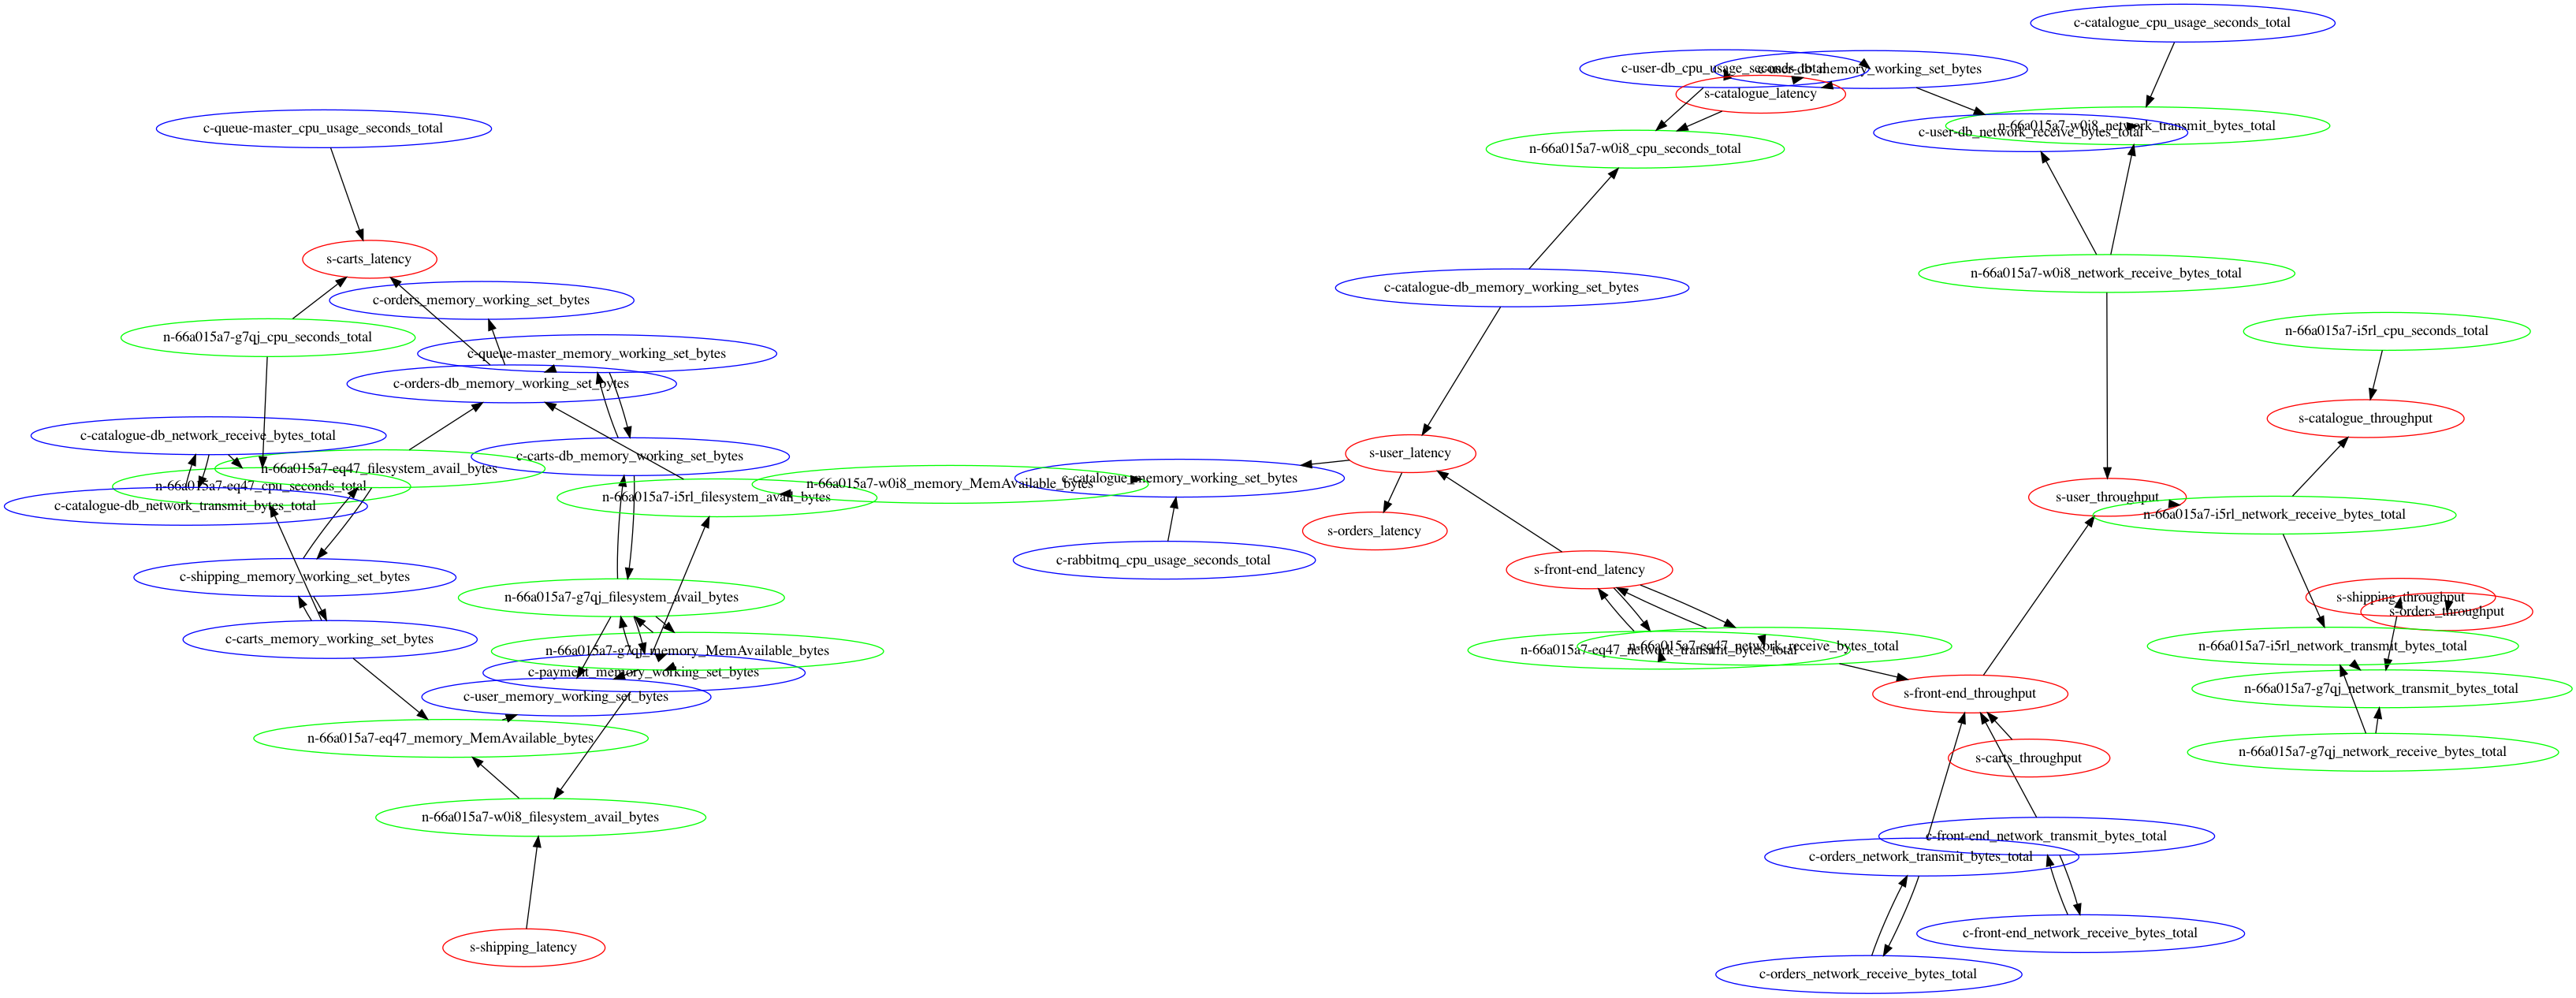

In [509]:
# Relabel
G = nx.relabel_nodes(G, labels)

# Exclude nodes that have no path to "s-front-end_latency" for visualization
remove_nodes = []
undirected_G = G.to_undirected()
for node in G.nodes():
    if not nx.has_path(undirected_G, node, "s-front-end_latency"):
        remove_nodes.append(node)
        continue
    if re.match("^s-", node):
        color = "red"
    elif re.match("^c-", node):
        color = "blue"
    else:
        color = "green"
    G.nodes[node]["color"] = color
G.remove_nodes_from(remove_nodes)

from IPython.display import Image, SVG, display

# prog=[‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’] 
agraph = nx.nx_agraph.to_agraph(G).draw(prog='sfdp', format='png')
Image(agraph)

## chi square test

In [48]:
# Determine the number of categories by Sturges' rule
data_size = len(data_df)
n_bins = int(np.log2(data_size) + 1)
print("Number of bins: {}".format(n_bins))

Number of bins: 8


In [49]:
disc_data_df = pd.DataFrame()
for col in data_df.columns:
    disc_data_df[col] = pd.cut(data_df[col], n_bins, labels=np.arange(0, n_bins))
disc_data_df

,c-catalogue_fs_io_current,c-catalogue_memory_working_set_bytes,c-catalogue_cpu_usage_seconds_total,c-catalogue-db_fs_io_current,c-catalogue-db_memory_working_set_bytes,c-catalogue-db_cpu_usage_seconds_total,c-orders_fs_io_current,c-orders_memory_working_set_bytes,c-orders_cpu_usage_seconds_total,c-orders-db_fs_io_current,...,s-carts_throughput,s-carts_latency,s-front-end_throughput,s-front-end_latency,s-payment_throughput,s-payment_latency,s-shipping_throughput,s-shipping_latency,s-user_throughput,s-user_latency
0,3,0,3,3,0,4,3,2,3,3,...,1,0,1,2,0,3,0,3,0,0
1,3,0,3,3,2,3,3,3,3,3,...,1,3,1,3,1,5,1,2,1,0
2,3,0,3,3,0,4,3,3,2,3,...,2,4,1,3,1,6,1,2,2,0
3,3,0,5,3,0,5,3,3,4,3,...,4,7,3,2,3,4,3,2,4,0
4,3,0,6,3,2,6,3,3,6,3,...,6,6,5,1,5,4,5,4,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,3,7,2,3,7,3,3,4,2,3,...,0,2,0,7,0,6,0,4,0,7
237,3,7,2,3,5,2,3,4,2,3,...,0,3,0,7,0,3,0,3,0,7
238,3,7,2,3,5,3,3,3,2,3,...,0,3,0,7,0,3,1,3,0,7
239,3,7,1,3,5,3,3,4,2,3,...,0,4,0,7,0,3,0,6,0,7


In [52]:
dm = disc_data_df.values
dm.shape

(241, 50)

In [53]:
from citest.chi_square import chi_square

(g, sep_set) = pcalg.estimate_skeleton(indep_test_func=chi_square,
                                 data_matrix=dm,
                                 alpha=0.01,
                                 init_graph=init_g)
g = pcalg.estimate_cpdag(skel_graph=g, sep_set=sep_set)

In [54]:
# Exclude nodes that have no neighbors for visualization
remove_nodes = list(g.nodes)
for edge in g.edges():
    for n in edge:
        try:
            remove_nodes.remove(n)
        except ValueError:
            pass
print(remove_nodes)
g.remove_nodes_from(remove_nodes)

[0, 3, 4, 5, 6, 7, 9, 11, 12, 15, 17, 18, 19, 20, 21, 24, 25, 27, 29, 30, 33, 34]


In [55]:
g = nx.relabel_nodes(g, labels)

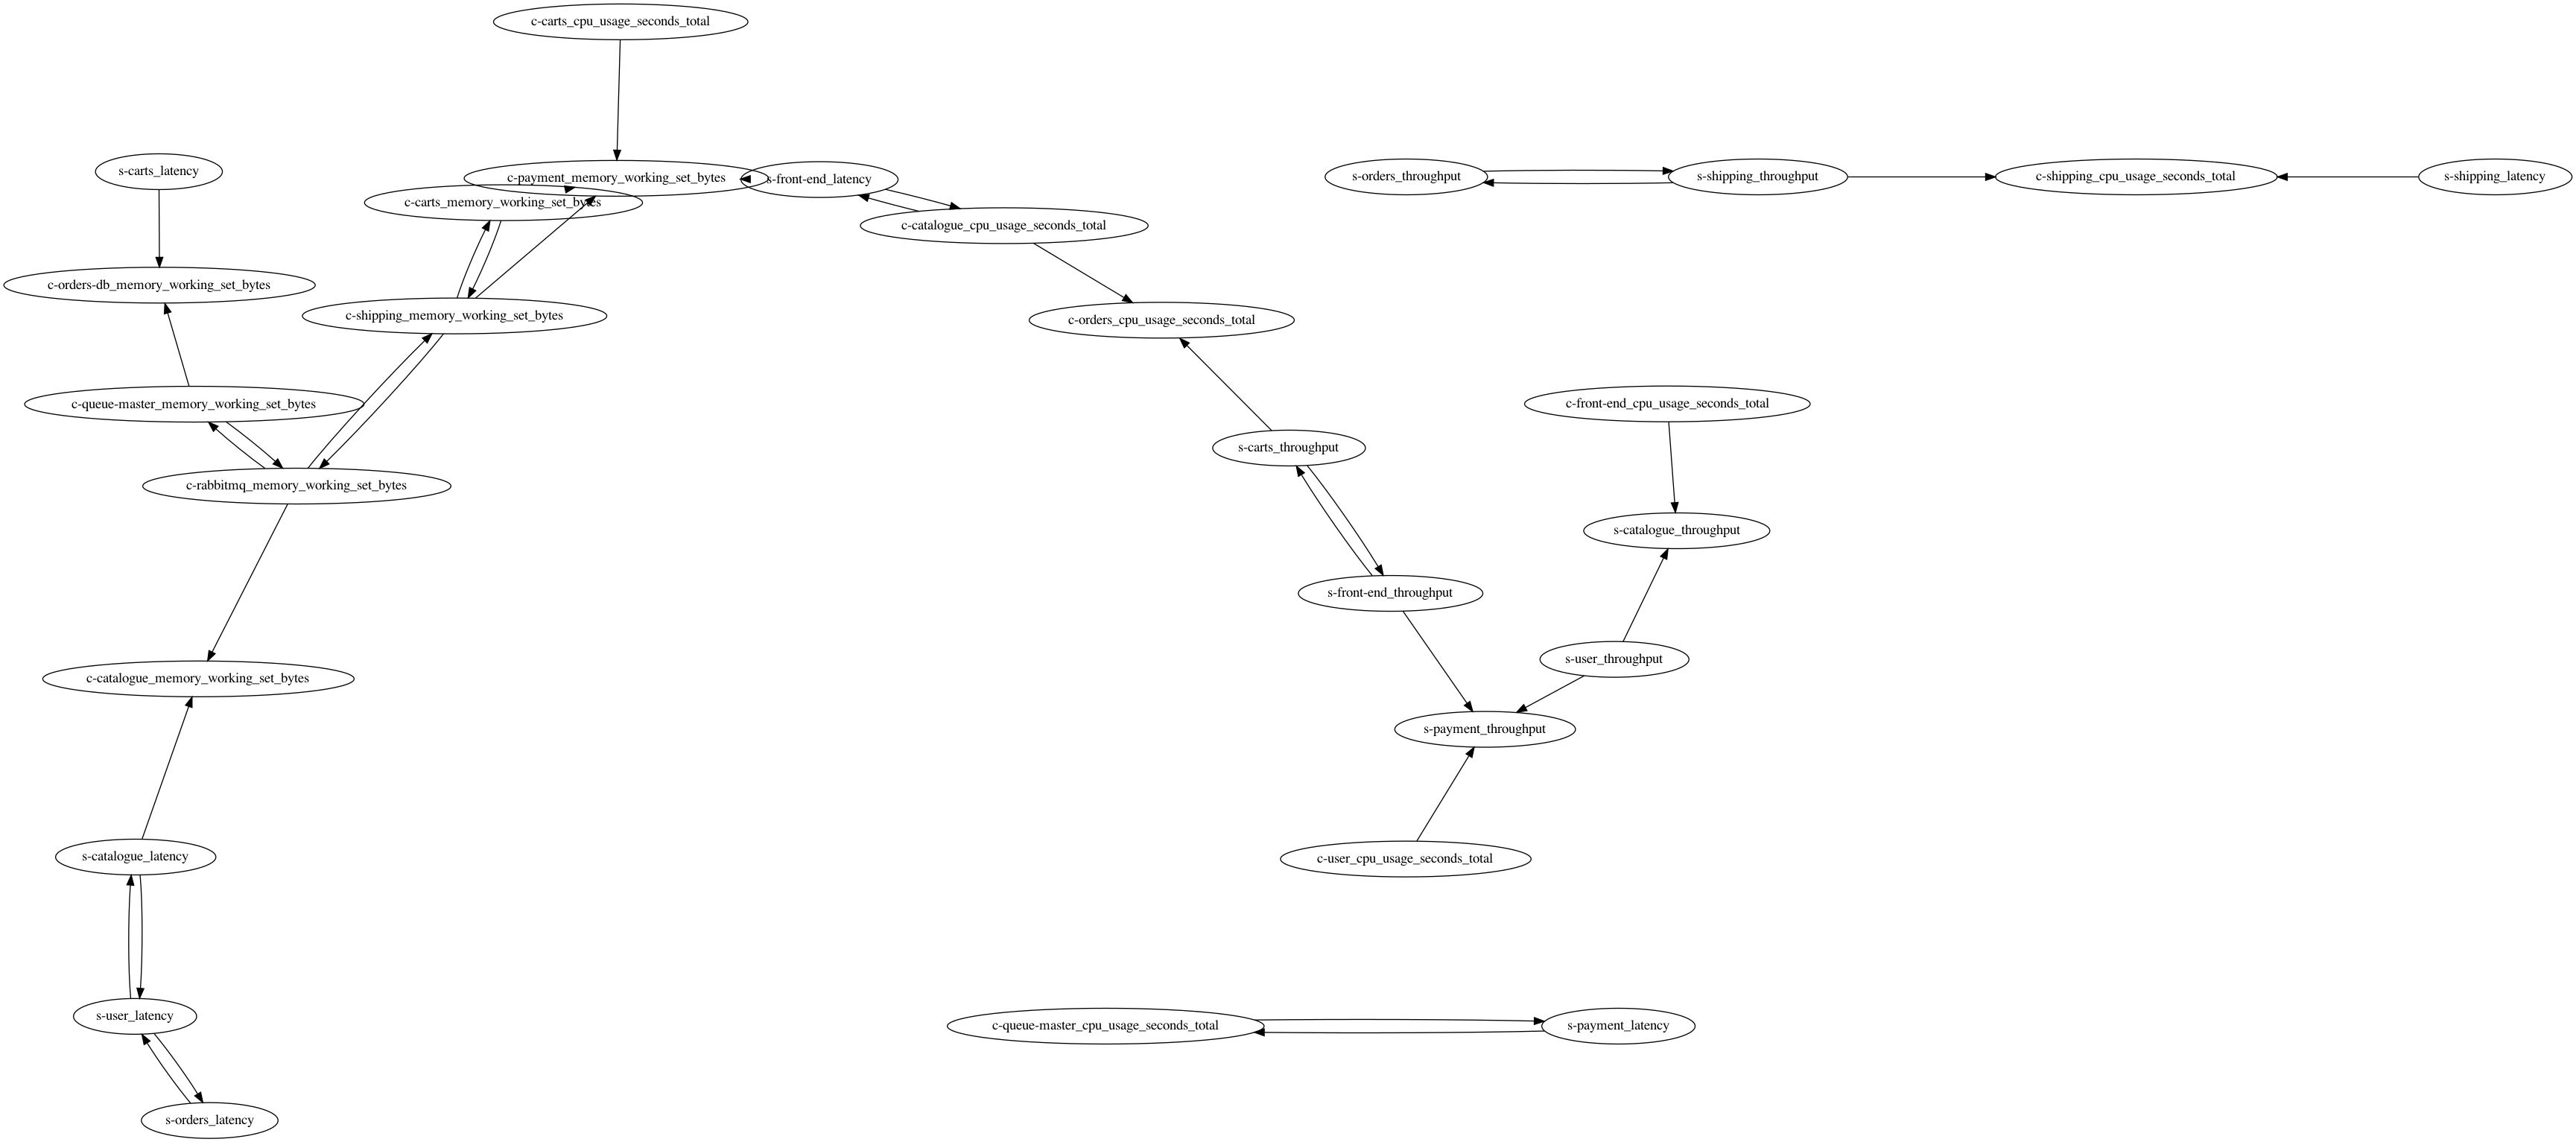

In [56]:
from IPython.display import Image, SVG, display

# prog=[‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’] 
agraph = nx.nx_agraph.to_agraph(g).draw(prog='sfdp', format='png')
Image(agraph)